In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

from ruspy.data.data_reading import data_reading
from ruspy.data.data_processing import data_processing

from ruspy.estimation.estimation import estimate
from ruspy.estimation.estimation_cost_parameters import calc_fixp
from ruspy.estimation.estimation_cost_parameters import lin_cost
from ruspy.estimation.estimation_cost_parameters import myopic_costs
from ruspy.estimation.estimation_cost_parameters import create_transition_matrix

from ruspy.simulation.simulation import simulate
from ruspy.simulation.robust_sim import get_worst_trans

from ruspy.plotting.value_zero import discount_utility
from ruspy.plotting.value_zero import calc_ev_0


In [25]:
# Prepare the raw data.
data_reading()

In [2]:
# Beta is set almost to one, as the agents objective is to maximize average cost.
beta = 0.9999
# 50 buses should be enough to gurantee convergence.
num_buses = 50
# Set the number of simulated periods to 80000. The first plot shows the convergence at this point.
num_periods = 80000
#Initilize a dictionary with values needed on the way.
init_dict = {
    'estimation':{
        'groups': 'group_4',
        'beta': beta,
        'maint_func': 'linear',
        'binsize': 5000,
        'states': 90,
        'max_it': 1000
    },
    'simulation':{
        'beta': beta,
        'periods': num_periods,
        'seed': 123,
        'maint_func': 'linear',
        'buses': num_buses
    }
    
}
np.random.seed(init_dict['simulation']['seed'])

In [27]:
repl_data = data_processing(init_dict['estimation'])
trans_results, cost_results = estimate(init_dict['estimation'], repl_data)
print(trans_results, cost_results)

     fun: 3140.570557231583
     jac: array([-4291.96844482, -4292.02462769, -4291.81420898])
 message: 'Optimization terminated successfully.'
    nfev: 158
     nit: 26
    njev: 26
  status: 0
 success: True
       x: array([0.39189477, 0.59529015, 0.01281509])       fun: 163.58583868384702
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.27373675e-05,  4.26325641e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 10
   status: 0
  success: True
        x: array([10.07776827,  2.29415225])


In [28]:
# The estimated probabilities are our starting point.
init_dict['simulation']['known probs'] = trans_results['x']
init_dict['simulation']['params'] = cost_results['x']

# Simulate a dataset with these values.
df, unobs, utilities, num_states = simulate(init_dict['simulation'])

# The theoretic value at time zero is computed.
costs = myopic_costs(num_states, lin_cost, init_dict['simulation']['params'])
trans_probs = np.array(init_dict['simulation']['known probs'])
trans_mat = create_transition_matrix(num_states, trans_probs)
ev = calc_fixp(num_states, trans_mat, costs, beta)

# Paramters for plotting
gridsize = 1000
num_points = int(num_periods/gridsize)

# Calculate the expected value at time zero
v_exp = np.full(num_points, calc_ev_0(ev, unobs, num_buses))
# Calculate the value at time 0 by discounting the utility
v_disc = discount_utility(np.zeros(num_points), num_buses, gridsize, num_periods, utilities, beta)
# Create a numpy array of the periods for plotting
periods = np.arange(0, num_periods, gridsize)

[]

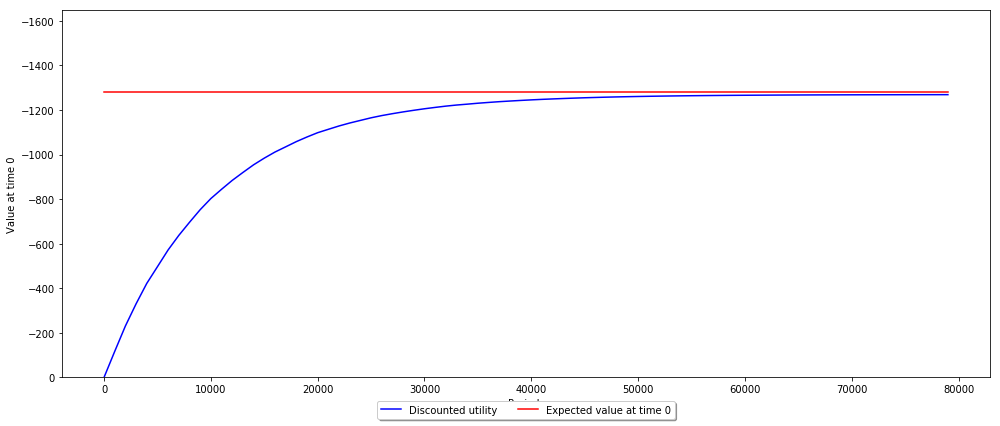

In [29]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax.set_ylim([0, 1.3 * v_disc[-1]])
ax.set_ylabel(r"Value at time 0")
ax.set_xlabel(r"Periods")
ax.plot(periods, v_disc, color='blue', label='Discounted utility')
ax.plot(periods, v_exp, color='red', label='Expected value at time 0')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)

plt.tight_layout()

plt.plot()


# Uncertainty

Now we want to introduce uncertain transition probabilites. Let <br/> <br/>

$\tilde{p}$ be the true underlying transition probability <br/>
$\hat{p_s}$ the transition probability for state s estimated from data <br/>
$\rho$ the size if the uncertainty set <br/>
$\omega$ the confidence level. <br/>
S S the number of states to which a transition is posible <br/>
$N_s$ the number of observations for state s <br/>
F the cdf of a chi-squared distribution<br/>

Then the following holds: 

$$ \omega = P\{ \tilde{p} \in \{ p : D(p||\hat{p_s}) \leq \rho \} \approx P\{ \chi^2_{|S| - 1} \leq 2N_s\rho \} = F_{|S| - 1}(2N_s\rho )$$
So 
$$\rho = F_{|S| - 1}^{-1}(\omega)/2N_s$$


As Rust doesn't estimate the transition probabilities for each state, that's the first modification I will need to do. The second is, that Rust took a weird convention or I didn't fully understand the his model yet: <br/>
Whenever a engine is replaced, he counts transition afterwards as an increase by one. In the following code cell, I estimate the model with the (for me intiutive) rule: <br/>
If an engine is replaced, I look at the following state, if that is 0,1 or 2. Also I implemented a counting function for the observations in each state.



In [30]:
trans_results, state_count, cost_results = estimate(init_dict['estimation'], repl_data, repl_4=False)
print(trans_results, cost_results, state_count)

     fun: 3153.831162720235
     jac: array([-4291.99981689, -4292.00033569, -4291.98428345])
 message: 'Optimization terminated successfully.'
    nfev: 60
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([0.39958063, 0.58760479, 0.01281458])       fun: 163.5826099336495
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.70530257e-05, 3.69482223e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 10
   status: 0
  success: True
        x: array([10.08896882,  2.28097345]) [171, 103, 115, 123, 119, 121, 103, 96, 98, 98, 95, 97, 92, 99, 84, 92, 91, 90, 82, 75, 68, 73, 72, 71, 64, 67, 62, 62, 55, 54, 56, 47, 49, 54, 54, 50, 50, 51, 50, 51, 57, 58, 47, 52, 47, 46, 45, 49, 47, 47, 44, 49, 40, 44, 35, 35, 36, 29, 34, 26, 26, 26, 22, 23, 22, 20, 13, 15, 17, 14, 6, 5, 3, 2, 2, 2, 2, 1]


In [31]:
# The size of the uncertainty set, such that the true transition probability lies with 95% in it
roh = chi2.ppf(0.95, len(trans_results['x']) - 1) / (2 * state_count[0])
roh

0.017518902184526255

In [32]:
# We seen above, that with the new estimation method, the paramters deviate not substantial from the "real" ones.
# I initialize the new values and roh now in the init_dict
init_dict['simulation']['known probs'] = trans_results['x']
init_dict['simulation']['params'] = cost_results['x']
init_dict['simulation']['roh'] = roh
# The worst case probabilites are calculated for a space size of 90. The size doesn't really makes a difference
# as my objective value is EV(0) anyway.
init_dict['simulation']['states'] = 90
worst_trans = get_worst_trans(init_dict['simulation'])
init_dict['simulation']['real probs'] = worst_trans
init_dict

{'estimation': {'groups': 'group_4',
  'beta': 0.9999,
  'maint_func': 'linear',
  'binsize': 5000,
  'states': 90,
  'max_it': 1000},
 'simulation': {'beta': 0.9999,
  'periods': 80000,
  'seed': 123,
  'maint_func': 'linear',
  'buses': 50,
  'known probs': array([0.39958063, 0.58760479, 0.01281458]),
  'params': array([10.08896882,  2.28097345]),
  'roh': 0.017518902184526255,
  'states': 90,
  'real probs': array([0.31258477, 0.66634951, 0.02106572])}}

In [33]:
# So with the worst case probabilites as the real ones, I calculate the new strategy
df, unobs, utilities, num_states = simulate(init_dict['simulation'])
# The cost vector for the new parameters
costs = myopic_costs(num_states, lin_cost, init_dict['simulation']['params'])

# For a better understanding, I use real_trans_probs instead of worst_case in the following
real_trans_probs = np.array(init_dict['simulation']['real probs'])
real_trans_mat = create_transition_matrix(num_states, real_trans_probs)
known_trans_probs = np.array(init_dict['simulation']['known probs'])
known_trans_mat = create_transition_matrix(num_states, known_trans_probs)

# So the calculated expected value of the real transition probabilities. We saw above, that if the 
# agent knows these, his discounted utility converges to that.
ev_real = calc_fixp(num_states, real_trans_mat, costs, beta)
v_exp_real = np.full(num_points, calc_ev_0(ev_real, unobs, num_buses))

# The expected value of transition probabilites the agent knows.
ev_known = calc_fixp(num_states, known_trans_mat, costs, beta)
v_exp_known = np.full(num_points, calc_ev_0(ev_known, unobs, num_buses))

# The discounted utility of the decision strategy
v_disc = discount_utility(np.zeros(num_points), num_buses, gridsize, num_periods, utilities, beta)


[]

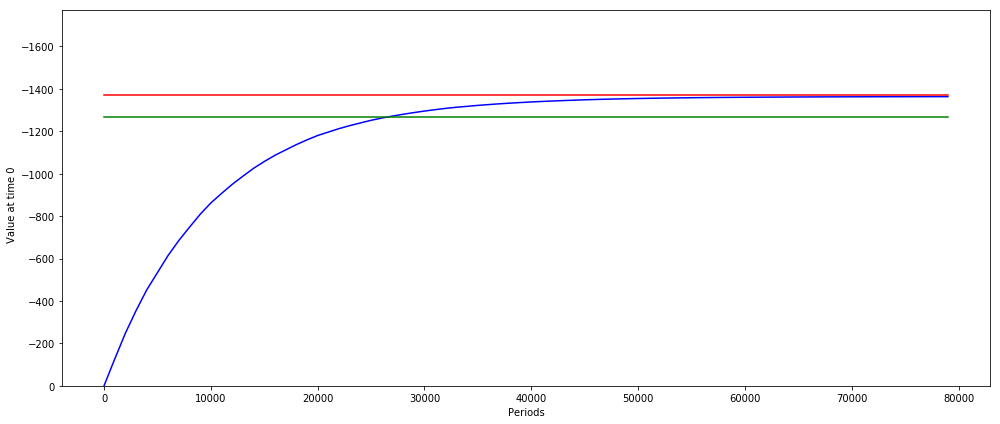

In [34]:
fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(111)

ax.set_ylim([0, 1.3 * v_disc[-1]])

ax.set_ylabel(r"Value at time 0    ")
ax.set_xlabel(r"Periods")

ax.plot(periods, v_disc, color='blue', label='Discounted utility')
ax.plot(periods, v_exp_real, color='red', label='Expected value of the real transition probabilites at time 0')
ax.plot(periods, v_exp_known, color='green',label='Expected value of the known transition probabilites at time 0')

plt.tight_layout()

plt.plot()

So we see, there is not a big of a gain. Lets look at it more closely and discretisize the state space a lot finer. Therefore we have to update the init_dict and then do the same steps as above:

In [35]:
init_dict

{'estimation': {'groups': 'group_4',
  'beta': 0.9999,
  'maint_func': 'linear',
  'binsize': 5000,
  'states': 90,
  'max_it': 1000},
 'simulation': {'beta': 0.9999,
  'periods': 80000,
  'seed': 123,
  'maint_func': 'linear',
  'buses': 50,
  'known probs': array([0.39958063, 0.58760479, 0.01281458]),
  'params': array([10.08896882,  2.28097345]),
  'roh': 0.017518902184526255,
  'states': 90,
  'real probs': array([0.31258477, 0.66634951, 0.02106572])}}

In [3]:
init_dict['estimation']['binsize'] = 1000
init_dict['estimation']['states'] = init_dict['simulation']['states'] = 450
init_dict['estimation']['max_it'] = 1000
repl_data = data_processing(init_dict['estimation'])
trans_results, state_count, cost_results = estimate(init_dict['estimation'], repl_data, repl_4=False)
print(trans_results, cost_results, state_count)

     fun: 7581.755519011549
     jac: array([-4291.98876953, -4292.00909424, -4292.01550293, -4291.99017334,
       -4292.00201416, -4291.99639893, -4292.00158691, -4291.63916016,
       -4290.96063232, -4292.23297119, -4291.89801025, -4290.65582275,
       -4290.68988037])
 message: 'Optimization terminated successfully.'
    nfev: 1336
     nit: 75
    njev: 75
  status: 0
 success: True
       x: array([2.86580358e-02, 8.10809022e-02, 2.79122939e-01, 2.46039699e-01,
       1.81733365e-01, 1.30242414e-01, 4.65982979e-02, 3.72817179e-03,
       4.66088648e-04, 6.98929448e-04, 9.31981148e-04, 4.66121756e-04,
       2.33055301e-04])       fun: 163.71080283705228
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        , -0.00012221])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 48
      nit: 11
   status: 0
  success: True
        x: array([10.13297317,  0.45596175]) [73, 38, 27, 11, 22, 18, 15, 28, 25, 17, 23, 26, 23, 25, 18, 26, 

In [4]:
# The size of the uncertainty set, such that the true transition probability lies with 95% in it
roh = chi2.ppf(0.99, len(trans_results['x']) - 1) / (2 * state_count[0])
roh

0.179568269215999

In [5]:
# We seen above, that with the new estimation method, the paramters deviate not substantial from the "real" ones.
# I initialize the new values and roh now in the init_dict
init_dict['simulation']['known probs'] = trans_results['x']
init_dict['simulation']['params'] = cost_results['x']
init_dict['simulation']['roh'] = roh
# The worst case probabilites are calculated for a space size of 90. The size doesn't really makes a difference
# as my objective value is EV(0) anyway.
worst_trans = get_worst_trans(init_dict['simulation'])
init_dict['simulation']['real probs'] = worst_trans
init_dict

{'estimation': {'groups': 'group_4',
  'beta': 0.9999,
  'maint_func': 'linear',
  'binsize': 1000,
  'states': 450,
  'max_it': 1000},
 'simulation': {'beta': 0.9999,
  'periods': 80000,
  'seed': 123,
  'maint_func': 'linear',
  'buses': 50,
  'states': 450,
  'known probs': array([2.86580358e-02, 8.10809022e-02, 2.79122939e-01, 2.46039699e-01,
         1.81733365e-01, 1.30242414e-01, 4.65982979e-02, 3.72817179e-03,
         4.66088648e-04, 6.98929448e-04, 9.31981148e-04, 4.66121756e-04,
         2.33055301e-04]),
  'params': array([10.13297317,  0.45596175]),
  'roh': 0.179568269215999,
  'real probs': array([0.00800196, 0.03247072, 0.16046191, 0.20431424, 0.21560599,
         0.2224589 , 0.11433146, 0.01315291, 0.00234766, 0.00509534,
         0.00973549, 0.00699588, 0.00502753])}}

In [6]:
gridsize = 1000
num_points = int(num_periods/gridsize)

In [7]:
# So with the worst case probabilites as the real ones, I calculate the new strategy
df, unobs, utilities, num_states = simulate(init_dict['simulation'])
# The cost vector for the new parameters
costs = myopic_costs(num_states, lin_cost, init_dict['simulation']['params'])

In [8]:
# For a better understanding, I use real_trans_probs instead of worst_case in the following
real_trans_probs = np.array(init_dict['simulation']['real probs'])
real_trans_mat = create_transition_matrix(num_states, real_trans_probs)
known_trans_probs = np.array(init_dict['simulation']['known probs'])
known_trans_mat = create_transition_matrix(num_states, known_trans_probs)

In [10]:
# So the calculated expected value of the real transition probabilities. We saw above, that if the 
# agent knows these, his discounted utility converges to that.
ev_real = calc_fixp(num_states, real_trans_mat, costs, beta)
v_exp_real = np.full(num_points, calc_ev_0(ev_real, unobs, num_buses))

In [9]:
num_states

1600

In [ ]:
# The expected value of transition probabilites the agent knows.
ev_known = calc_fixp(num_states, known_trans_mat, costs, beta)
v_exp_known = np.full(num_points, calc_ev_0(ev_known, unobs, num_buses))

In [ ]:
# The discounted utility of the decision strategy
v_disc = discount_utility(np.zeros(num_points), num_buses, gridsize, num_periods, utilities, beta)

In [ ]:
periods = np.arange(0, num_periods, gridsize)
fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(111)

ax.set_ylim([0, 1.3 * v_disc[-1]])

ax.set_ylabel(r"Value at time 0")
ax.set_xlabel(r"Periods")

ax.plot(periods, v_disc, color='blue', label='Discounted utility')
ax.plot(periods, v_exp_real, color='red', label='Expected value of the real transition probabilites at time 0')
ax.plot(periods, v_exp_known, color='green',label='Expected value of the known transition probabilites at time 0')

plt.tight_layout()

plt.plot()